In [1]:
import torch, time
import numpy as np

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [2]:
import torchvision

train_set = torchvision.datasets.MNIST("./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST("./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt

f, l = next(iter(train_loader))
'''
f: (Batch, 1, 28, 28)
l: (Batch)
'''
print(f.shape)
print(l.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


In [5]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, list_N_hiddens, n_classes):
        super().__init__()
        self.input_layer = nn.Linear(input_size, list_N_hiddens[0])
        self.bn1 = nn.BatchNorm1d(list_N_hiddens[0])
        self.h_layers = nn.Sequential()
        for i in range(len(list_N_hiddens) - 1):
            self.h_layers.add_module(f"conv_{i+1}", nn.Linear(list_N_hiddens[i], list_N_hiddens[i+1]))
            self.h_layers.add_module(f"bn_{i+1}", nn.BatchNorm1d(list_N_hiddens[i+1]))
            self.h_layers.add_module(f"relu_{i+1}", nn.ReLU())
        self.output_layer = nn.Linear(list_N_hiddens[-1], n_classes)
        self.ReLU = nn.ReLU()
        self.Softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = torch.flatten(x,1)
        # Since x.shape() = (batch, 1, 28, 28),
        # "torch.flatten(x,1)" would flatten x from index of 1
        # so, the "batch-dimension" survives -> resulting shape: (batch, 1*28*28)
        x = self.ReLU(self.input_layer(x))
        x = self.h_layers(x)
        x = self.Softmax(self.output_layer(x))

        return x

In [6]:
model = MLP(28**2, [512, 128, 32], 10).to(device)
loss = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(f"Model: {model}\n\nLoss: {loss}\n\nOptimizer: {optimizer}")

Model: MLP(
  (input_layer): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (h_layers): Sequential(
    (conv_1): Linear(in_features=512, out_features=128, bias=True)
    (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU()
    (conv_2): Linear(in_features=128, out_features=32, bias=True)
    (bn_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
  (ReLU): ReLU()
  (Softmax): Softmax(dim=-1)
)

Loss: BCELoss()

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, model_save_path):
    model.train()

    size = len(dataloader)
    datasize = len(dataloader.dataset)

    OH_labels = [[1,0,0,0,0,0,0,0,0,0],
                 [0,1,0,0,0,0,0,0,0,0],
                 [0,0,1,0,0,0,0,0,0,0],
                 [0,0,0,1,0,0,0,0,0,0],
                 [0,0,0,0,1,0,0,0,0,0],
                 [0,0,0,0,0,1,0,0,0,0],
                 [0,0,0,0,0,0,1,0,0,0],
                 [0,0,0,0,0,0,0,1,0,0],
                 [0,0,0,0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,0,0,0,1]]

    loss_hist=[]
    acc_hist=[]

    for epoch in range(10):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X,Y) in enumerate(dataloader):
            X = X.to(device).float()
            target = []

            for y in Y:
                target.append(OH_labels[int(y)])

            target = torchvision.transforms.ToTensor()(np.array(target)).squeeze(0).to(device).float()
            # ToTensor() automatically adds an extra dimension when converting from a numpy array.
            # [Because ToTensor() is designed primarily for image data, which typically has multiple channels]

            # If you want to remove the extra dimension,
            # (1) Use "torch.from_numpy()"
            # (2) Remove the singleton dimension using "torch.squeeze()"

            output = model(X)

            loss = loss_fn(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==target.argmax(1)).detach().cpu().sum().item()

            if batch % 20 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [8]:
loss_hist, acc_hist = train_loop(train_loader, model, loss, optimizer, "E:/model_save_path/Practice/MLP_1.pt")

Start epoch : 1
Batch loss : 0.33444 0/235
Batch loss : 0.17492 20/235
Batch loss : 0.13061 40/235
Batch loss : 0.09572 60/235
Batch loss : 0.07491 80/235
Batch loss : 0.06875 100/235
Batch loss : 0.04156 120/235
Batch loss : 0.04116 140/235
Batch loss : 0.04294 160/235
Batch loss : 0.02312 180/235
Batch loss : 0.03381 200/235
Batch loss : 0.02119 220/235
Loss : 0.07282 ACC : 93.73%
End epoch : 1
Epoch time : 0.0 min 6.233144998550415 sec

Start epoch : 2
Batch loss : 0.02538 0/235
Batch loss : 0.01555 20/235
Batch loss : 0.01903 40/235
Batch loss : 0.01801 60/235
Batch loss : 0.01778 80/235
Batch loss : 0.01072 100/235
Batch loss : 0.01958 120/235
Batch loss : 0.01505 140/235
Batch loss : 0.01571 160/235
Batch loss : 0.02029 180/235
Batch loss : 0.01449 200/235
Batch loss : 0.01385 220/235
Loss : 0.01668 ACC : 97.78%
End epoch : 2
Epoch time : 0.0 min 5.989882469177246 sec

Start epoch : 3
Batch loss : 0.00764 0/235
Batch loss : 0.01026 20/235
Batch loss : 0.01113 40/235
Batch loss : 

In [14]:
def test_loop(dataloader, model, model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    model.eval()

    labels = [[1,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,0,0,1]]

    pred, target = [], []
    correct = 0

    for (X,Y) in dataloader:
        X = X.to(device).float()
        OH_y = []
        for y in Y:
            OH_y.append(labels[int(y)])
            target.append(labels[int(y)])

        OH_y = torchvision.transforms.ToTensor()(np.array(OH_y)).squeeze(0).to(device).float()

        output = model(X)

        for o in output:
            pred.append(o.detach().cpu().tolist())

        correct+=(output.argmax(1)==OH_y.argmax(1)).detach().cpu().sum().item()

    print(f"ACC: {(correct/len(dataloader.dataset)*100):>.2f}%")

    return pred, target

In [15]:
pred_list, target_list = test_loop(test_loader, model, "E:/model_save_path/Practice/MLP_1.pt")

ACC: 98.07%


<Axes: >

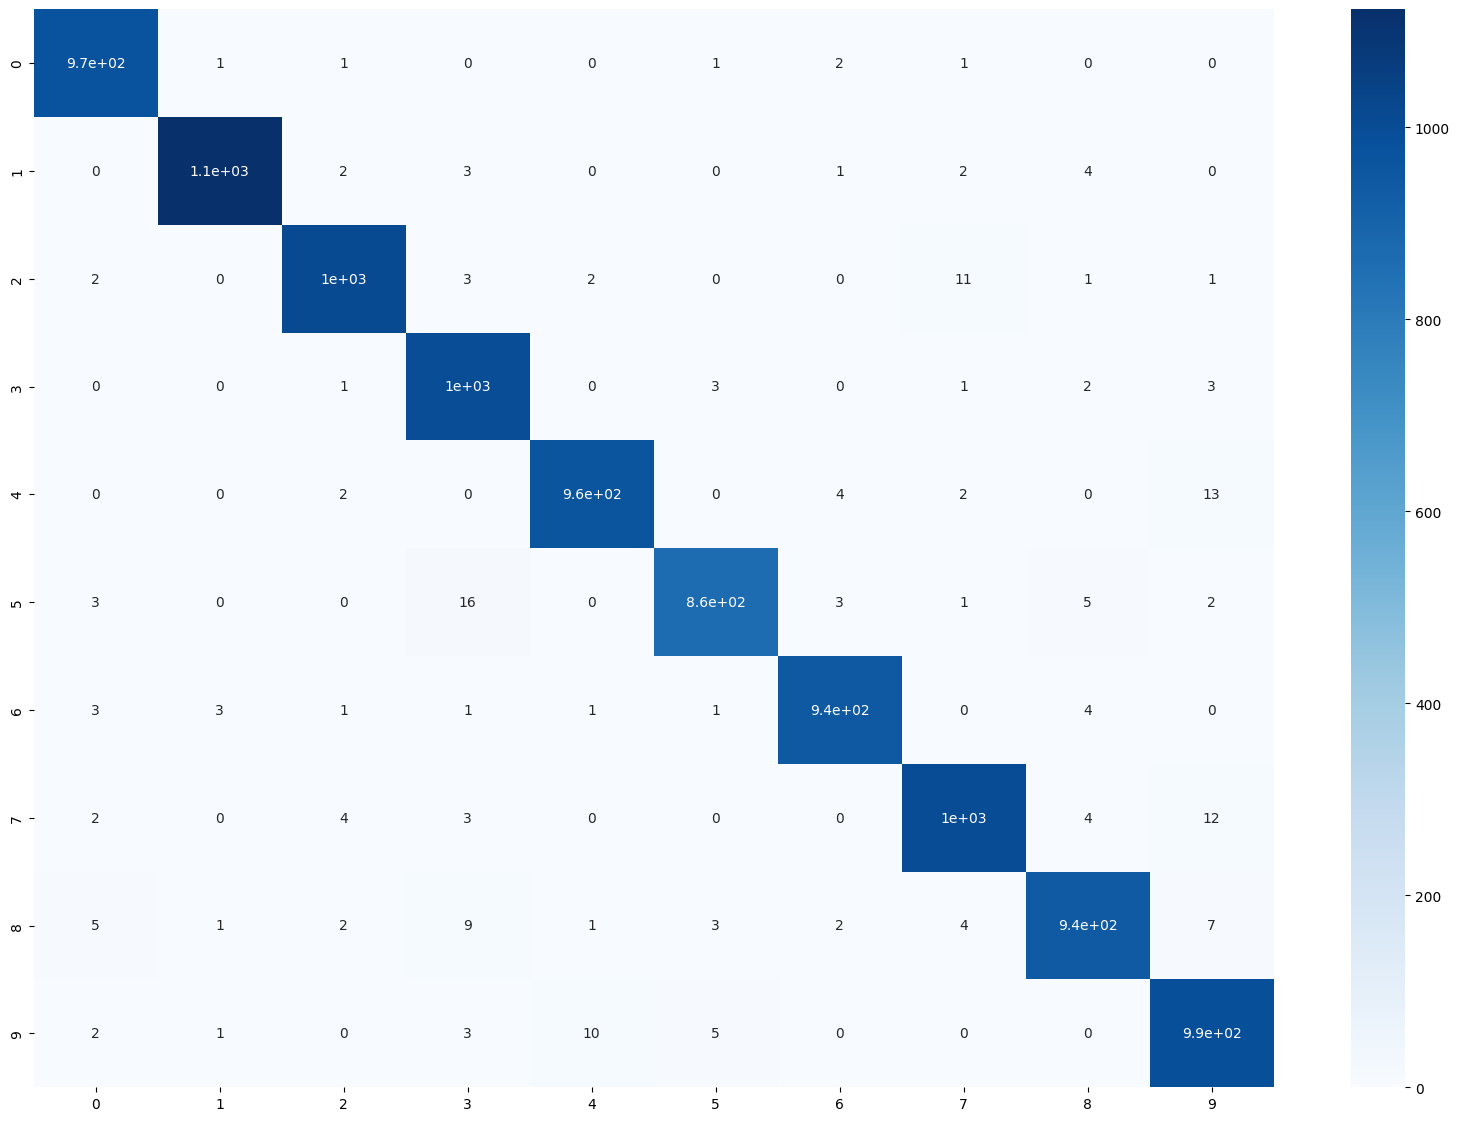

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

OH_pred = []
for vector in pred_list:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []
for vector in target_list:
    OH_label.append(np.argmax(vector, axis=0))

import matplotlib
matplotlib.pyplot.figure(figsize=(20,14))
cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')